<a href="https://colab.research.google.com/github/MadhurGyani/sementic_segmentation/blob/main/Satellite_Imagery_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code from Part 1 Exercise - Satellite Imagery Data Preparation



In [1]:
!pip install patchify


In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler = MinMaxScaler()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_root_folder = '/content/drive/MyDrive/'

In [6]:
dataset_name = "Semantic segmentation dataset"

In [7]:
image_patch_size = 256

In [8]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [10]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


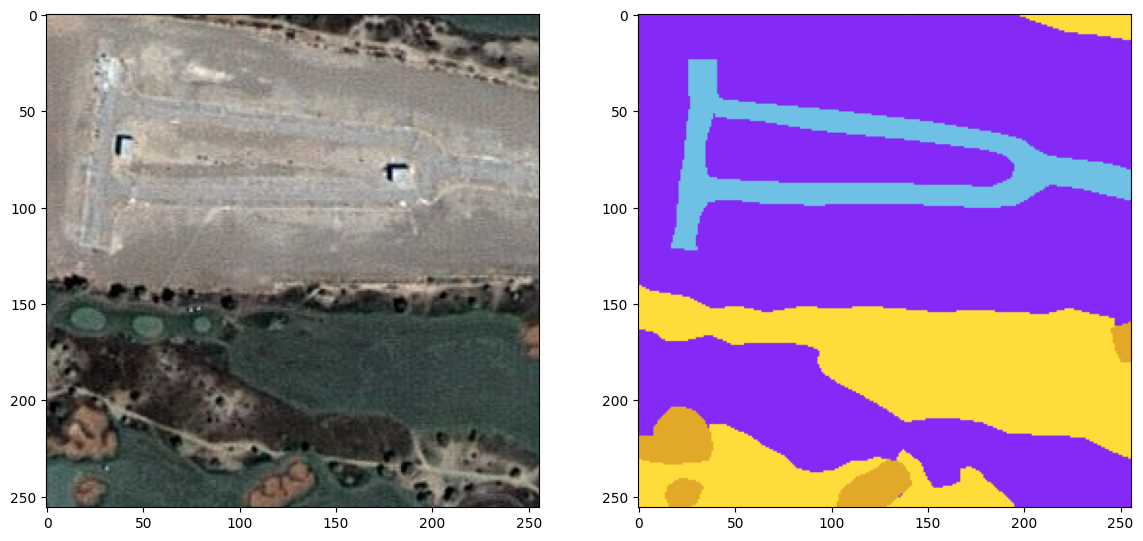

In [11]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [12]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [13]:
label = individual_patched_mask

In [14]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 0
  label_segment[np.all(label == class_road, axis=-1)] = 0
  label_segment[np.all(label == class_building, axis=-1)] = 0
  label_segment[np.all(label == class_vegetation, axis=-1)] = 1
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 0
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [15]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [16]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [17]:
np.unique(labels)

array([0, 1], dtype=uint8)

In [18]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1]


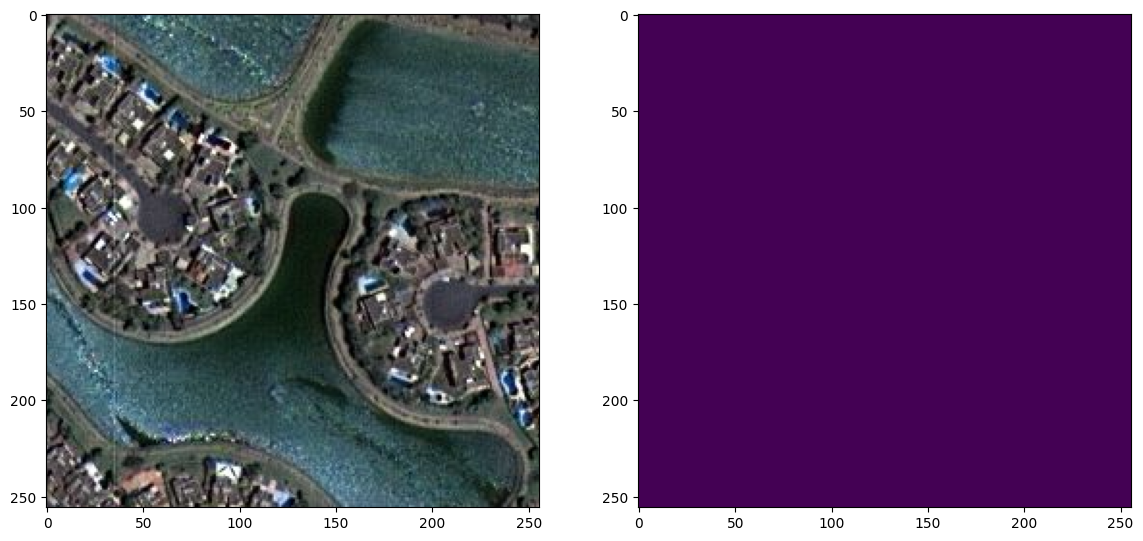

In [19]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [20]:
total_classes = len(np.unique(labels))

In [21]:
total_classes

2

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [24]:
master_trianing_dataset = image_dataset

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 2)
(142, 256, 256, 2)


In [28]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [29]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
2


# Coding for Part 2: Deep Learning with Satellite Imagery Data

In [30]:
# !pip install --upgrade keras

$ pip install git+https://github.com/qubvel/segmentation_models

In [31]:
! pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00


In [32]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [33]:
from keras import backend as K

In [34]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = tf.keras.backend.flatten(y_true)
  y_pred_flatten = tf.keras.backend.flatten(y_pred)
  intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [35]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [36]:
metrics = ["accuracy", jaccard_coef]

In [37]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
2


In [38]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [39]:
model = get_deep_learning_model()

In [40]:
# Please uncomment this line to get model confiuration
# model.get_config()

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [41]:
weights = [0.0005 ,0.9995]

In [42]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [43]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [44]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [45]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [46]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [47]:
import tensorflow as tf

In [48]:
tf.keras.backend.clear_session()


In [49]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/10
51/51 [==============================] - 585s 11s/step - loss: 0.9196 - accuracy: 0.8578 - jaccard_coef: 0.6064 - val_loss: 0.8887 - val_accuracy: 0.7900 - val_jaccard_coef: 0.6020
Epoch 2/10
51/51 [==============================] - 538s 11s/step - loss: 0.8537 - accuracy: 0.8480 - jaccard_coef: 0.7203 - val_loss: 0.9543 - val_accuracy: 0.6797 - val_jaccard_coef: 0.5286
Epoch 3/10
51/51 [==============================] - 556s 11s/step - loss: 0.8216 - accuracy: 0.8746 - jaccard_coef: 0.7718 - val_loss: 0.9469 - val_accuracy: 0.7370 - val_jaccard_coef: 0.5941
Epoch 4/10
51/51 [==============================] - 551s 11s/step - loss: 0.8115 - accuracy: 0.8872 - jaccard_coef: 0.7910 - val_loss: 0.9545 - val_accuracy: 0.7386 - val_jaccard_coef: 0.5896
Epoch 5/10
51/51 [==============================] - 527s 10s/step - loss: 0.7947 - accuracy: 0.9052 - jaccard_coef: 0.8179 - val_loss: 0.9451 - val_accuracy: 0.7332 - val_jaccard_coef: 0.5821
Epoch 6/10
51/51 [======================

In [ ]:
# model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
# model_history = model.fit(X_train, y_train,
#                           batch_size=16,
#                           verbose=1,
#                           epochs=10,
#                           validation_data=(X_test, y_test),
#                           shuffle=False)

In [ ]:
# # Import necessary libraries
# import tensorflow as tf
# from tensorflow.keras import layers

# # Define the jaccard_coef function
# def jaccard_coef(y_true, y_pred):
#     y_true_flatten = tf.keras.backend.flatten(y_true)
#     y_pred_flatten = tf.keras.backend.flatten(y_pred)
#     intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
#     final_coef_value = (intersection + 1.0) / (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten) - intersection + 1.0)
#     return final_coef_value

# # Define the model


# # Compile the model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[jaccard_coef])

# # Train the model
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# # Evaluate the model
# model.evaluate(X_test, y_test)

In [ ]:
# !pip install --upgrade keras

In [ ]:
history_a = model_history

In [ ]:
history_a.history

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
model_history.params

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
len(y_pred)

In [ ]:
y_pred

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

In [ ]:
y_pred_argmax

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [ ]:
import random


In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [ ]:
model.save("satellite_segmentation_full.h5")

In [ ]:
!ls -lah

# **Bhopal image**

In [ ]:
from PIL import Image

# Increase the maximum allowed pixels limit
Image.MAX_IMAGE_PIXELS = 237305856  # Adjust this number based on your specific needs

# Now load the image
image = Image.open('/content/drive/MyDrive/bhopal image/2024-02-20-00_00_2024-02-20-23_59_Sentinel-2_L2A_True_color (4).jpg')


In [ ]:
from patchify import patchify, unpatchify
import cv2
import numpy as np

# Load img
img = cv2.imread('/content/drive/MyDrive/bhopal image/2024-02-20-00_00_2024-02-20-23_59_Sentinel-2_L2A_True_color (4).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define patch size
patch_size = 256  # 64x64 patches

size_x = (img.shape[1]//patch_size)*patch_size
size_y = (img.shape[0]//patch_size)*patch_size
#print("{} --- {} - {}".format(img.shape, size_x, size_y))
img = Image.fromarray(img)
img = img.crop((0,0, size_x, size_y))
#print("({},  {})".format(img.size[0],img.size[1]))
img = np.array(img)


In [ ]:
patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)  # Assume step size is equal to patch size for no overlap


In [ ]:
predictions = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j, 0]
        test_image_input=patch
        test_image_input = np.expand_dims(test_image, 0)

        prediction = model.predict(test_image_input)
        predicted_image = np.argmax(prediction, axis=3)
        predicted_image = predicted_image[0,:,:]
        predictions.append(predicted_image)

# Assuming patches are processed back into their original shape
#predicted_patches = np.array(predictions).reshape(patches.shape)


In [ ]:
import numpy as np

# Convert list to NumPy array
predictions_array = np.array(predictions)

# Ensure the predictions_array is correctly shaped:
print(predictions_array.shape)
# It should be something like (num_patches, height, width, channels)

# If not, you need to adjust how you gather your predictions

# Once confirmed, reshape it:
reshaped_predictions = predictions_array.reshape((51, 71, 1, 256, 256, 3))


In [ ]:
reconstructed_image = unpatchify(predicted_patches, img.shape)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Use str(img) or plt.imshow(img) as the title
plt.title(str(img))
#plt.title(plt.imshow(img))
plt.imshow(patches[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Processed Image')
plt.imshow(predictions[0])
plt.axis('off')

plt.show()